# Random walk interpolate

This notebook contains a small toy example, where TACTiS is used to predict the distribution of intermediate values of a random walk process, given values before and after them.

In [1]:
# Configuration
import os
import sys
REPO_NAME = "tactis"
def get_repo_basepath():
    cd = os.path.abspath(os.curdir)
    return cd[:cd.index(REPO_NAME) + len(REPO_NAME)]
REPO_BASE_PATH = get_repo_basepath()
sys.path.append(REPO_BASE_PATH)

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from tactis.model.tactis import TACTiS

In [3]:
device = torch.device("cuda")

## Dataset definition

In [4]:
def generate_random_data():
    # Make a simple dataset just to test
    np.random.seed(12345)
    
    n = 100000
    p = 10

    X = np.cumsum(np.random.randn(p, n), axis=1)

    X_train = X[:, : n//2]
    X_test = X[:, n//2 :]
    
    return X_train, X_test

## Model definition

In [5]:
def create_net():
    net = TACTiS(
        num_series=10,
        series_embedding_dim=5,
        input_encoder_layers=3,
        input_encoding_normalization=True,
        data_normalization="standardization",
        loss_normalization="series",
        positional_encoding={
            "dropout": 0.0,
        },
        temporal_encoder={
            "attention_layers": 3,
            "attention_heads": 3,
            "attention_dim": 16,
            "attention_feedforward_dim": 16,
            "dropout": 0.0,
        },
        copula_decoder={
            "min_u": 0.01,
            "max_u": 0.99,
            "attentional_copula": {
                "attention_heads": 3,
                "attention_layers": 3,
                "attention_dim": 16,
                "mlp_layers": 3,
                "mlp_dim": 16,
                "resolution": 50,
            },
            "dsf_marginal": {
                "mlp_layers": 2,
                "mlp_dim": 8,
                "flow_layers": 2,
                "flow_hid_dim": 8,
            },
        },
    )
    return net.to(device)

## Model training

In [6]:
def step(net, optimizer, batch_size, data, hist_length_before, hist_length_after, pred_length):
    max_idx = data.shape[1] - (hist_length_before + hist_length_after + pred_length)
    
    hist_values = []
    pred_values = []
    for _ in range(batch_size):
        idx = np.random.randint(0, max_idx)
        hist_values.append(np.concatenate([
            data[:, idx:idx+hist_length_before],
            data[:, idx+hist_length_before+pred_length:idx+hist_length_before+pred_length+hist_length_after]
        ], axis=1))
        pred_values.append(data[:, idx+hist_length_before:idx+hist_length_before+pred_length])
    
    # [batch, series, time steps]
    hist_value = torch.Tensor(hist_values).to(device)
    pred_value = torch.Tensor(pred_values).to(device)
    hist_time = torch.cat([
        torch.arange(0, hist_length_before, device=device),
        torch.arange(hist_length_before+pred_length, hist_length_before+pred_length+hist_length_after, device=device),
    ])[None, :].expand(batch_size, -1)
    pred_time = torch.arange(hist_length_before, hist_length_before + pred_length, device=device)[None, :].expand(batch_size, -1)
    
    optimizer.zero_grad()
    loss = net.loss(hist_time, hist_value, pred_time, pred_value)
    loss.backward()
    optimizer.step()
    
    return loss.item()

In [7]:
net = create_net()
data_train, data_test = generate_random_data()
optimizer = torch.optim.RMSprop(net.parameters(), lr=1e-3, weight_decay=0)

In [8]:
avg_loss = []

NUM_EPOCHS = 1000  # The model is very slow to train 
NUM_BATCHES = 100

for epoch in range(NUM_EPOCHS):
    running_sum = 0
    for batch in range(NUM_BATCHES):
        running_sum += step(net, optimizer, 256, data_train, 5, 5, 10)
    avg_loss.append(running_sum / NUM_BATCHES)

The loss function of TACTiS often contains multiple plateaus.
For example, the first plateau can be the model correctly learning the global distribution, before learning the distribution conditioned on the history, and then learning the correlations between time steps.

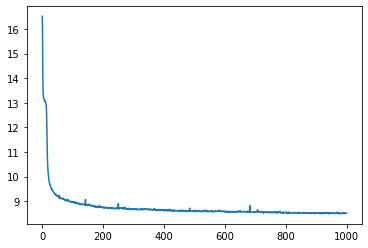

In [9]:
plt.figure()
plt.plot(avg_loss)

## Sampling from the model

In [10]:
def sample(net, num_samples, data, hist_length_before, hist_length_after, pred_length):
    max_idx = data.shape[1] - (hist_length_before + hist_length_after + pred_length)
    
    idx = np.random.randint(0, max_idx)
    hist_value = torch.Tensor(np.concatenate([
        data[:, idx:idx+hist_length_before],
        data[:, idx+hist_length_before+pred_length:idx+hist_length_before+pred_length+hist_length_after]
    ], axis=1)).to(device)
    pred_value = torch.Tensor(data[:, idx+hist_length_before:idx+hist_length_before+pred_length]).to(device)
    
    # [batch, series, time steps]
    hist_value = hist_value[None, :, :]
    pred_value = pred_value[None, :, :]
    hist_time = torch.cat([
        torch.arange(0, hist_length_before, device=device),
        torch.arange(hist_length_before+pred_length, hist_length_before+pred_length+hist_length_after, device=device),
    ])[None, :]
    pred_time = torch.arange(hist_length_before, hist_length_before + pred_length, device=device)[None, :]

    samples = net.sample(num_samples, hist_time, hist_value, pred_time)   
    return samples, torch.cat([hist_value, pred_value], axis=2), torch.cat([hist_time, pred_time], axis=1)

In [11]:
samples, pred_value, timesteps = sample(net, 1000, data_test, 5, 5, 10)

# Reorder for easy plotting
permutation = [*range(5), *range(10, 20), *range(5, 10)]
samples = samples[:, :, permutation, :]
pred_value = pred_value[:, :, permutation]
timesteps = timesteps[:, permutation]

In [12]:
def plot_single_series(samples, target, timesteps, index):
    s_samples = samples[0, index, :, :].cpu().numpy()
    s_timesteps = timesteps[0, :].cpu().numpy()
    s_target = target[0, index, :].cpu().numpy()
    
    plt.figure()
    
    for zorder, quant, color, label in [
        [1, 0.05, (0.75,0.75,1), "5%-95%"],
        [2, 0.10, (0.25,0.25,1), "10%-90%"],
        [3, 0.25, (0,0,0.75), "25%-75%"],
    ]:
        plt.fill_between(
            s_timesteps,
            np.quantile(s_samples, quant, axis=1),
            np.quantile(s_samples, 1 - quant, axis=1),
            facecolor=color,
            interpolate=True,
            label=label,
            zorder=zorder,
        )
    
    plt.plot(
        s_timesteps,
        np.quantile(s_samples, 0.5, axis=1),
        color=(0.5,0.5,0.5),
        linewidth=3,
        label="50%",
        zorder=4,
    )
    
    plt.plot(s_timesteps, s_target, color=(0, 0, 0), linewidth=2, zorder=5, label="ground truth")
    
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [1, 2, 3, 4, 0]
    plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order])
    
    plt.show()

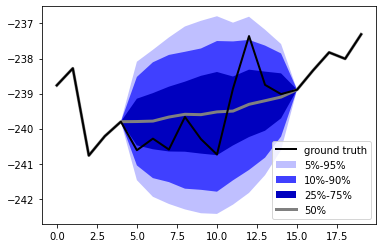

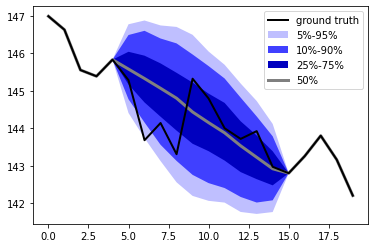

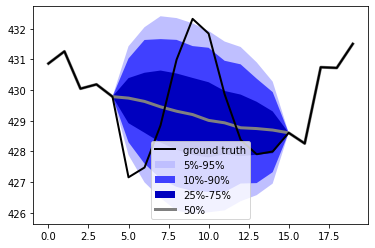

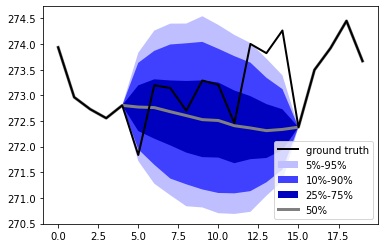

In [13]:
for i in range(4):
    plot_single_series(samples, pred_value, timesteps, i)

The variance of the random walk process for the interpolation scenario is more complicated, but can still be calculated analytically. It grows until the interpolation window midpoint before going back down.

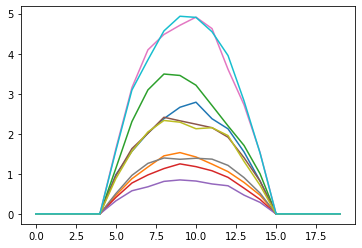

In [14]:
plt.figure()
plt.plot(samples[0, :, :, :].var(dim=2).cpu().transpose(0,1))
plt.show()

The correlations should increase as we go to the middle time steps, especially for close time steps.

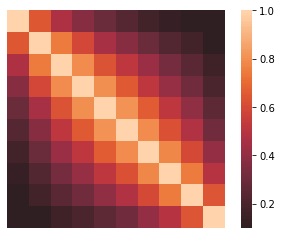

In [15]:
corrcoef = 0
for b in range(samples.shape[0]):
    for v in range(samples.shape[1]):
        spl = samples[b,v,5:15,:].cpu().numpy()
        corrcoef = corrcoef + np.corrcoef(spl)
corrcoef /= (samples.shape[0] * samples.shape[1])

plt.figure()

svm = sns.heatmap(corrcoef, robust=True, center=0, xticklabels=False, yticklabels=False)
plt.gca().set_aspect('equal', 'box')
plt.show()